In [1]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os
import regionmask

from Functions import * 

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

# Data loading

In [2]:
''' Examples of data loading of moisture sources

Data is loaded per individual ensemble member for each model.
All data is converted to mm evaporative sources over the whole time period

WRF-WVT is not included yet, as well CHc Lagranto and univie FLEXPART  
'''

########################################################
## WRF-WVT                                            ##
########################################################

# Just csv file because of nature of simulations #

########################################################
## WAM2layers                                         ##
########################################################
directory_str = "results WAM2layers/"
directory =  os.fsencode(directory_str)
n=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".nc"): 
        if n ==0:
            temp = xr.open_dataset(os.path.join(directory_str, filename))
            a_gridcell, lx, ly = get_grid_info(temp)
            srcs_wam2layers = temp["e_track"]* 1000 / a_gridcell[:, None]
            n+=1
        else:
            temp = xr.open_dataset(os.path.join(directory_str, filename))
            a_gridcell, lx, ly = get_grid_info(temp)
            srcs_wam2layers += temp["e_track"]* 1000 / a_gridcell[:, None]
            n+=1
        continue
    else:
        continue

# Data loading this way gives an error message for me while plotting, but in principe it should work
dsall = xr.open_mfdataset('results WAM2layers/backtrack_*T00-00.nc', combine = 'nested', concat_dim='time')      
lat = dsall.latitude.values
lon = dsall.longitude.values
a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(lat, lon)
E_track_totalmm = (dsall/ a_gridcell_new) *1000 # mm
srcs_wam2layers_new = E_track_totalmm["e_track"].sum('time') # mm

########################################################
## University of Vigo                                 ##
########################################################
srcs_Vigo_e1_Stohl    = xr.open_dataset("results Uvigo/ERA5_Stohl_backwardreg.nc")["E_P"]
srcs_Vigo_e2_Sodemann = xr.open_dataset("results Uvigo/ERA5_sodemann_reg.nc")["E_P"]
    
########################################################
## UTRACK - Arie STaal                                ##
########################################################
directory_str = "results Utrack Arie Staal/moisture_tracking_intercomparsion/"
directory =  os.fsencode(directory_str)

dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing48h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e1 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing24h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e2 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing12h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e3 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing24h_dt025h_1000p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e4 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing24h_dt010h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e5 = dsall["moisture_source"].sum("time")*1000.0

########################################################
## HAMSTER (Ghent)                                    ##
########################################################

# E1: Sodemann #
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens1_sod08/bias_corrected_20220810120000_sod08.nc")
srcs_ghent_e1 = temp["E2P_BC"].mean("time") #Mean over time to remove time dimension

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens1_sod08/bias_corrected_202208" + str(date) + "120000_sod08.nc")
    srcs_ghent_e1 += temp["E2P_BC"].mean("time")
    
# E2: FAS19 (Fremme + Sodemann, 2019) #
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens2_fas19/bias_corrected_20220810120000_fas19.nc")
srcs_ghent_e2 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens2_fas19/bias_corrected_202208" + str(date) + "120000_fas19.nc")
    srcs_ghent_e2 += temp["E2P_BC"].mean("time")
    
# E3: FAS19 (Fremme + Sodemann, 2019) #
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens3_rh20/bias_corrected_20220810120000_rh20.nc")
srcs_ghent_e3 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens3_rh20/bias_corrected_202208" + str(date) + "120000_rh20.nc")
    srcs_ghent_e3 += temp["E2P_BC"].mean("time")
    
# E4: 
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens4_allabl/bias_corrected_20220810120000_allabl.nc")
srcs_ghent_e4 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens4_allabl/bias_corrected_202208" + str(date) + "120000_allabl.nc")
    srcs_ghent_e4 += temp["E2P_BC"].mean("time")

########################################################
## TRACMASS Dipanjan Dey                              ## 
########################################################
nrdays = 15
ds_TRACMASS = xr.open_dataset("results TRACMASS Dipanjan Dey/TRACMASS_diagnostics.nc") #Evaporative sources (and preicp?) mm/day
ds_pr_TRACMASS = xr.open_dataset("results TRACMASS Dipanjan Dey/PR_ERA5_TRACMASS.nc") #Precip ERA5 and TRACMASS Comparison
#convert to -180 to 180 lon
ds_TRACMASS.coords['lon'] = (ds_TRACMASS.coords['lon'] + 180) % 360 - 180
ds_TRACMASS = ds_TRACMASS.sortby(ds_TRACMASS.lon)

srcs_TRACMASS = ds_TRACMASS["E_TRACMASS"]*nrdays #Units of data is mm/day but we want mm over whole time period

########################################################
## FLEXPART-Watersip TatFanCheng                      ##
########################################################
filename = "results FLEXPART_WaterSip_TatFanCheng/Pakistan_case_FLEXPART_WaterSip_TatFanCheng/WaterSip_Cb_20220810-20220824_Pakistan_box.nc"
ds_flexpart_watersip = xr.open_dataset(filename)
#convert to -180 to 180 lon
ds_flexpart_watersip.coords['lon'] = (ds_flexpart_watersip.coords['lon'] + 180) % 360 - 180
ds_flexpart_watersip = ds_flexpart_watersip.sortby(ds_TRACMASS.lon)
srcs_flexpart_watersip = ds_flexpart_watersip.sum("time")["Cb"]

########################################################
## Flexpart Ru Xu                                     ##
########################################################
ds_flexpart_xu = xr.open_dataset("results Ru_Xu_FLEXPART/submit/e_daily.nc")
srcs_flexpart_xu = ds_flexpart_xu["variable"].sum("time")

In [3]:
### Calculate (area weighted) fractional sources ###
# In WAM2layers and the flexpart simulations of Xu the lon lat names are different #
srcs_wam2layers_frac = calc_fractional_sources(srcs_wam2layers,lon_name="longitude",lat_name="latitude")
srcs_Vigo_e1_Stohl_frac = calc_fractional_sources(srcs_Vigo_e1_Stohl)
srcs_Vigo_e2_Sodemann_frac = calc_fractional_sources(srcs_Vigo_e2_Sodemann)
srcs_utrack_e1_frac = calc_fractional_sources(srcs_utrack_e1)
srcs_utrack_e2_frac = calc_fractional_sources(srcs_utrack_e2)
srcs_utrack_e3_frac = calc_fractional_sources(srcs_utrack_e3)
srcs_utrack_e4_frac = calc_fractional_sources(srcs_utrack_e4)
srcs_utrack_e5_frac = calc_fractional_sources(srcs_utrack_e5)
srcs_ghent_e1_frac  = calc_fractional_sources(srcs_ghent_e1)
srcs_ghent_e2_frac  = calc_fractional_sources(srcs_ghent_e2)
srcs_ghent_e3_frac  = calc_fractional_sources(srcs_ghent_e3)
srcs_ghent_e4_frac  = calc_fractional_sources(srcs_ghent_e4)
srcs_TRACMASS_frac  = calc_fractional_sources(srcs_TRACMASS)
srcs_flexpart_watersip_frac = calc_fractional_sources(srcs_flexpart_watersip)
srcs_flexpart_xu_frac = calc_fractional_sources(srcs_flexpart_xu,lon_name="longitude",lat_name="latitude")

# Sample plots

/usr/local/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

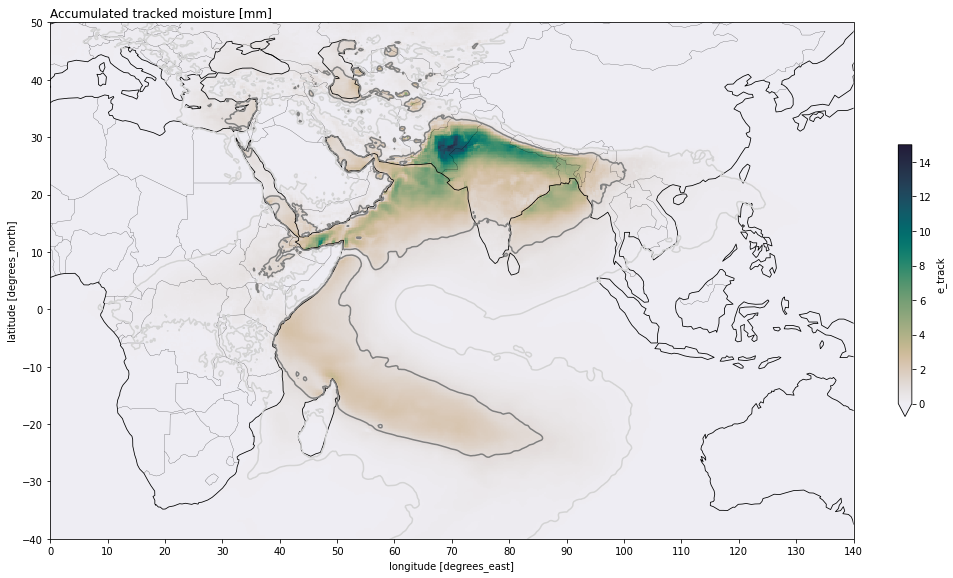

In [5]:
# Make sample figure (in this case of WAM2layers)
my_projection = crs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

srcs_wam2layers.plot(
        vmin=0,
        vmax=15,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5),
    )
srcs_wam2layers.plot.contour(ax=ax, levels=[0.1, 1], colors=["lightgrey", "grey"])
ax.set_title("Accumulated tracked moisture [mm]", loc="left")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(0, 140)
ax.set_ylim(-40, 50)
plt.savefig("Wam2layers_sources_Pakistan.png")


## Uncorrected plot of moisture sources

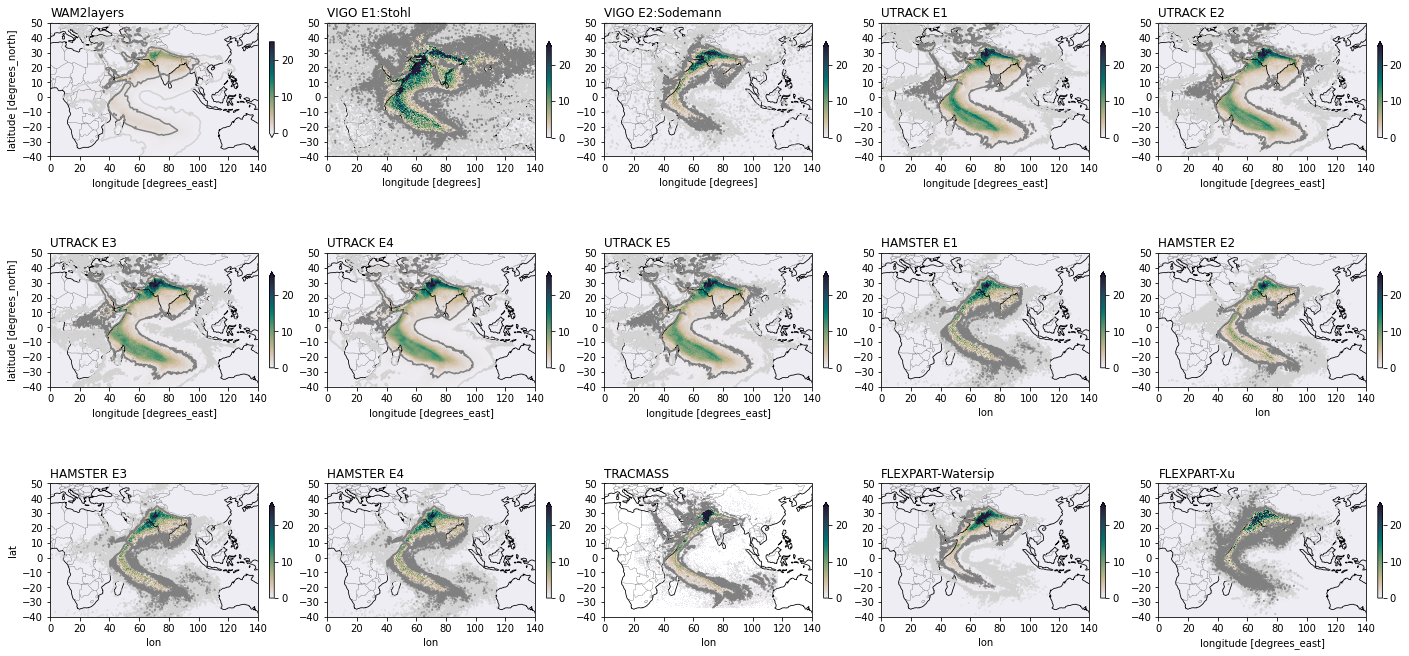

In [42]:
### MAKE PLOT OF DIFFERENT ENSEMBLE MEMBERS (not corrected for different sums) ###
my_projection = crs.PlateCarree(central_longitude=0)

# Make figure
fig, axs = plt.subplots(3, 5, figsize=(24, 12),subplot_kw={'projection': crs.PlateCarree()},sharey=False)

#Ensemble member 1:
srcs_wam2layers.plot(ax=axs[0,0],vmin=0,vmax=25,robust=False,cmap=cm.rain,
                     cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_wam2layers.plot.contour(ax=axs[0,0], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,0].set_title("WAM2layers", loc="left")

#Ensemble member 2:
srcs_Vigo_e1_Stohl.plot(ax=axs[0,1],vmin=0,vmax=25,robust=False,cmap=cm.rain,
                        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_Vigo_e1_Stohl.plot.contour(ax=axs[0,1], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,1].set_title("VIGO E1:Stohl", loc="left")

#Ensemble member 3:
srcs_Vigo_e2_Sodemann.plot(ax=axs[0,2],vmin=0,vmax=25,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_Vigo_e2_Sodemann.plot.contour(ax=axs[0,2], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,2].set_title("VIGO E2:Sodemann", loc="left")

#Ensemble member 4:
srcs_utrack_e1.plot(ax=axs[0,3],vmin=0,vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e1.plot.contour(ax=axs[0,3], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,3].set_title("UTRACK E1", loc="left")

#Ensemble member 5:
srcs_utrack_e2.plot(ax=axs[0,4],vmin=0, vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e2.plot.contour(ax=axs[0,4], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,4].set_title("UTRACK E2", loc="left")

#Ensemble member 6:
srcs_utrack_e3.plot(ax=axs[1,0],vmin=0,vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e3.plot.contour(ax=axs[1,0], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,0].set_title("UTRACK E3", loc="left")

#Ensemble member 7:
srcs_utrack_e4.plot(ax=axs[1,1], vmin=0,vmax=25,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e4.plot.contour(ax=axs[1,1], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,1].set_title("UTRACK E4", loc="left")

#Ensemble member 8:
srcs_utrack_e5.plot(ax=axs[1,2], vmin=0, vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e5.plot.contour(ax=axs[1,2], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,2].set_title("UTRACK E5", loc="left")

#Ensemble member 9:
srcs_ghent_e1.plot(ax=axs[1,3],vmin=0,vmax=25,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None), )
srcs_ghent_e1.plot.contour(ax=axs[1,3], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,3].set_title("HAMSTER E1", loc="left")

#Ensemble member 10:
srcs_ghent_e2.plot(ax=axs[1,4], vmin=0, vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e2.plot.contour(ax=axs[1,4], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,4].set_title("HAMSTER E2", loc="left")

#Ensemble member 11:
srcs_ghent_e3.plot(ax=axs[2,0], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e3.plot.contour(ax=axs[2,0], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,0].set_title("HAMSTER E3", loc="left")

#Ensemble member 12:
srcs_ghent_e4.plot(ax=axs[2,1], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e4.plot.contour(ax=axs[2,1], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,1].set_title("HAMSTER E4", loc="left")

#Ensemble member 13:
srcs_TRACMASS.plot(ax=axs[2,2], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_TRACMASS.plot.contour(ax=axs[2,2], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,2].set_title("TRACMASS", loc="left")

#Ensemble member 14:
srcs_flexpart_watersip.plot(ax=axs[2,3], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_flexpart_watersip.plot.contour(ax=axs[2,3], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,3].set_title("FLEXPART-Watersip", loc="left")

#Ensemble member 15:
srcs_flexpart_xu.plot(ax=axs[2,4], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_flexpart_xu.plot.contour(ax=axs[2,4], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,4].set_title("FLEXPART-Xu", loc="left")

#GENERAL Features which should appear for each subplot
for i in range(3):
    for j in range(5):
        axs[i,j].add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
        axs[i,j].add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

        axs[i,j].set_xticks(np.arange(-180, 181, 20), crs=my_projection)
        axs[i,j].set_yticks(np.arange(-90, 91, 10), crs=my_projection)
        axs[i,j].set_xlim(0, 140)
        axs[i,j].set_ylim(-40, 50)
        
        #Dismiss label of y-axis, except for left most column
        if(j > 0):
            axs[i,j].set_ylabel("")

fig.savefig("MoistureSources_NotCorrected_all.png",dpi=300)

## Fractional moisture sources

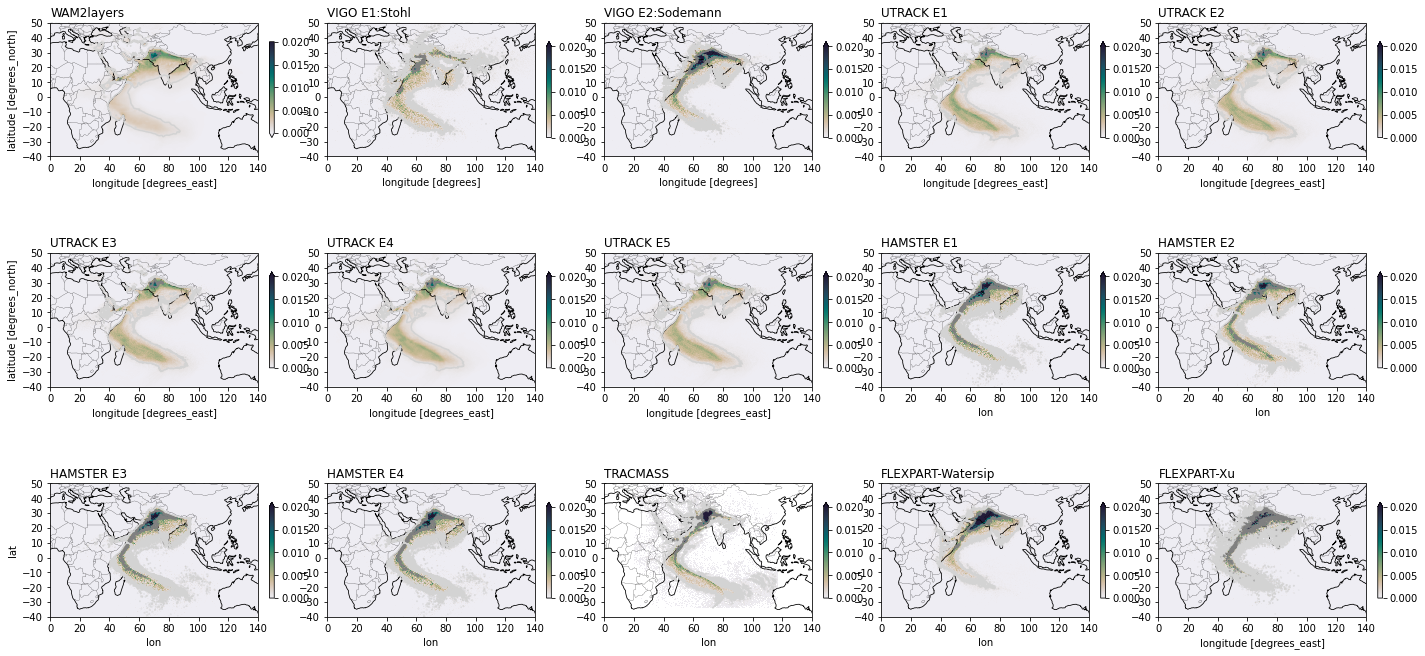

In [5]:
#General plotting options
vmin = 0
vmax = 0.02
contour_levels = [0.001, 0.01]

### MAKE PLOT OF DIFFERENT ENSEMBLE MEMBERS (Fractional) ###
my_projection = crs.PlateCarree(central_longitude=0)

# Make figure
fig, axs = plt.subplots(3, 5, figsize=(24, 12),subplot_kw={'projection': crs.PlateCarree()},sharey=False)

#Ensemble member 1:
srcs_wam2layers_frac.plot(ax=axs[0,0],vmin=vmin,vmax=vmax,robust=False,cmap=cm.rain,
                     cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_wam2layers_frac.plot.contour(ax=axs[0,0], levels=contour_levels, colors=["lightgrey", "grey"])
axs[0,0].set_title("WAM2layers", loc="left")

#Ensemble member 2:
srcs_Vigo_e1_Stohl_frac.plot(ax=axs[0,1],vmin=vmin,vmax=vmax,robust=False,cmap=cm.rain,
                        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_Vigo_e1_Stohl_frac.plot.contour(ax=axs[0,1], levels=contour_levels, colors=["lightgrey", "grey"])
axs[0,1].set_title("VIGO E1:Stohl", loc="left")

#Ensemble member 3:
srcs_Vigo_e2_Sodemann_frac.plot(ax=axs[0,2],vmin=vmin,vmax=vmax,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_Vigo_e2_Sodemann_frac.plot.contour(ax=axs[0,2], levels=contour_levels, colors=["lightgrey", "grey"])
axs[0,2].set_title("VIGO E2:Sodemann", loc="left")

#Ensemble member 4:
srcs_utrack_e1_frac.plot(ax=axs[0,3],vmin=vmin,vmax=vmax, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e1_frac.plot.contour(ax=axs[0,3], levels=contour_levels, colors=["lightgrey", "grey"])
axs[0,3].set_title("UTRACK E1", loc="left")

#Ensemble member 5:
srcs_utrack_e2_frac.plot(ax=axs[0,4],vmin=vmin, vmax=vmax, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e2_frac.plot.contour(ax=axs[0,4], levels=contour_levels, colors=["lightgrey", "grey"])
axs[0,4].set_title("UTRACK E2", loc="left")

#Ensemble member 6:
srcs_utrack_e3_frac.plot(ax=axs[1,0],vmin=vmin,vmax=vmax, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e3_frac.plot.contour(ax=axs[1,0], levels=contour_levels, colors=["lightgrey", "grey"])
axs[1,0].set_title("UTRACK E3", loc="left")

#Ensemble member 7:
srcs_utrack_e4_frac.plot(ax=axs[1,1], vmin=vmin,vmax=vmax,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e4_frac.plot.contour(ax=axs[1,1], levels=contour_levels, colors=["lightgrey", "grey"])
axs[1,1].set_title("UTRACK E4", loc="left")

#Ensemble member 8:
srcs_utrack_e5_frac.plot(ax=axs[1,2], vmin=vmin, vmax=vmax, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e5_frac.plot.contour(ax=axs[1,2], levels=contour_levels, colors=["lightgrey", "grey"])
axs[1,2].set_title("UTRACK E5", loc="left")

#Ensemble member 9:
srcs_ghent_e1_frac.plot(ax=axs[1,3],vmin=vmin,vmax=vmax,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None), )
srcs_ghent_e1_frac.plot.contour(ax=axs[1,3], levels=contour_levels, colors=["lightgrey", "grey"])
axs[1,3].set_title("HAMSTER E1", loc="left")

#Ensemble member 10:
srcs_ghent_e2_frac.plot(ax=axs[1,4], vmin=vmin, vmax=vmax, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e2_frac.plot.contour(ax=axs[1,4], levels=contour_levels, colors=["lightgrey", "grey"])
axs[1,4].set_title("HAMSTER E2", loc="left")

#Ensemble member 11:
srcs_ghent_e3_frac.plot(ax=axs[2,0], vmin=vmin, vmax=vmax, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e3_frac.plot.contour(ax=axs[2,0], levels=contour_levels, colors=["lightgrey", "grey"])
axs[2,0].set_title("HAMSTER E3", loc="left")

#Ensemble member 12:
srcs_ghent_e4_frac.plot(ax=axs[2,1], vmin=vmin, vmax=vmax, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e4_frac.plot.contour(ax=axs[2,1], levels=contour_levels, colors=["lightgrey", "grey"])
axs[2,1].set_title("HAMSTER E4", loc="left")

#Ensemble member 13:
srcs_TRACMASS_frac.plot(ax=axs[2,2], vmin=vmin, vmax=vmax, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_TRACMASS_frac.plot.contour(ax=axs[2,2], levels=contour_levels, colors=["lightgrey", "grey"])
axs[2,2].set_title("TRACMASS", loc="left")

#Ensemble member 14:
srcs_flexpart_watersip_frac.plot(ax=axs[2,3], vmin=vmin, vmax=vmax, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_flexpart_watersip_frac.plot.contour(ax=axs[2,3], levels=contour_levels, colors=["lightgrey", "grey"])
axs[2,3].set_title("FLEXPART-Watersip", loc="left")

#Ensemble member 15:
srcs_flexpart_xu_frac.plot(ax=axs[2,4], vmin=vmin, vmax=vmax, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_flexpart_xu_frac.plot.contour(ax=axs[2,4], levels=contour_levels, colors=["lightgrey", "grey"])
axs[2,4].set_title("FLEXPART-Xu", loc="left")

#GENERAL Features which should appear for each subplot
for i in range(3):
    for j in range(5):
        axs[i,j].add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
        axs[i,j].add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

        axs[i,j].set_xticks(np.arange(-180, 181, 20), crs=my_projection)
        axs[i,j].set_yticks(np.arange(-90, 91, 10), crs=my_projection)
        axs[i,j].set_xlim(0, 140)
        axs[i,j].set_ylim(-40, 50)
        
        #Dismiss label of y-axis, except for left most column
        if(j > 0):
            axs[i,j].set_ylabel("")
            
fig.savefig("MoistureSources_Fractional_all.png",dpi=300)


## CMIP REGIONS

/usr/local/lib/python3.7/site-packages/regionmask/core/plot.py:232: FutureWarning: 'proj' has been renamed to 'projection'
  warnings.warn("'proj' has been renamed to 'projection'", FutureWarning)
/usr/local/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` proper

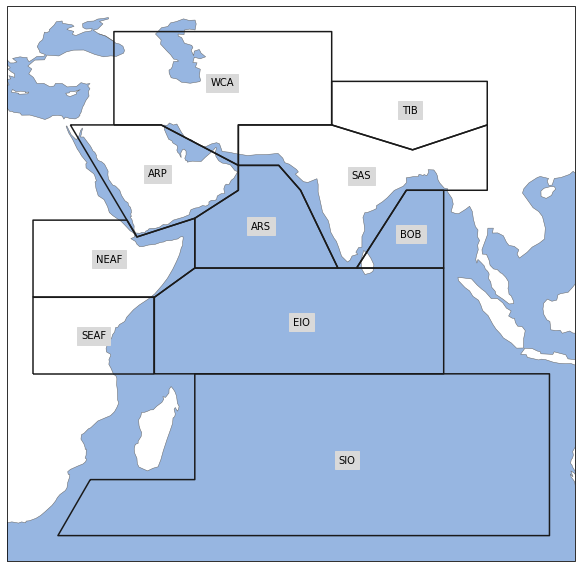

In [6]:
#### Sources per region, import necessary libraries ####
my_projection = crs.PlateCarree(central_longitude=0)

source_regions = xr.open_dataset("IPCCregions_Pakistancase.nc")
source_regions.names

ar6_all = regionmask.defined_regions.ar6.all
selected_regions = ar6_all[['NEAF', 'SEAF', 'WCA', 'TIB', 'ARP', 'SAS', 'ARS', 'BOB', 'EIO',
       'SIO']]

plt.figure(figsize=(12,8))
ax = selected_regions.plot(proj=my_projection, label="abbrev", add_ocean=True)
plt.tight_layout()
plt.savefig("Defined regions.png")

In [36]:
## Calculation fraction (in %) 
srcs_wam2layers_regional, weights = calc_regional_sources(srcs_wam2layers_frac,selected_regions,lon_name="longitude",lat_name = "latitude")
srcs_Vigo_e1_Stohl_regional, weights = calc_regional_sources(srcs_Vigo_e1_Stohl_frac,selected_regions)
srcs_Vigo_e2_Sodemann_regional, weights =  calc_regional_sources(srcs_Vigo_e2_Sodemann_frac,selected_regions,
                                                       weights=weights) #We can use the same weights again
srcs_utrack_e1_regional, weights = calc_regional_sources(srcs_utrack_e1_frac,selected_regions)
srcs_utrack_e2_regional, weights = calc_regional_sources(srcs_utrack_e2_frac,selected_regions,weights=weights)
srcs_utrack_e3_regional, weights = calc_regional_sources(srcs_utrack_e3_frac,selected_regions,weights=weights)
srcs_utrack_e4_regional, weights = calc_regional_sources(srcs_utrack_e4_frac,selected_regions,weights=weights)
srcs_utrack_e5_regional, weights = calc_regional_sources(srcs_utrack_e5_frac,selected_regions,weights=weights)

srcs_ghent_e1_regional, weights = calc_regional_sources(srcs_ghent_e1_frac,selected_regions)
srcs_ghent_e2_regional, weights = calc_regional_sources(srcs_ghent_e2_frac,selected_regions,weights=weights)
srcs_ghent_e3_regional, weights = calc_regional_sources(srcs_ghent_e3_frac,selected_regions,weights=weights)
srcs_ghent_e4_regional, weights = calc_regional_sources(srcs_ghent_e4_frac,selected_regions,weights=weights)

srcs_TRACMASS_regional, weights =  calc_regional_sources(srcs_TRACMASS_frac,selected_regions) 
srcs_flexpart_watersip_regional, weights = calc_regional_sources(srcs_flexpart_watersip_frac,selected_regions)
srcs_flexpart_xu_regional, weights =  calc_regional_sources(srcs_flexpart_xu_frac,selected_regions,lon_name="longitude",lat_name = "latitude")

/usr/local/lib/python3.7/site-packages/regionmask/core/mask.py:169: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/regionmask/core/mask.py:169: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/regionmask/core/mask.py:169: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/regionmask/core/mask.py:169: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  FutureWarning,
/usr/local/lib/python3.7/site-packag

'\n# Vigo\nmask_3D = selected_regions.mask_3D(srcs_Vigo_e1_Stohl_frac)\nweights = np.cos(np.deg2rad(srcs_Vigo_e1_Stohl_frac.lat))\nweights = (mask_3D * weights).fillna(0)\n\nsrcs_Vigo_e1_Stohl_regional = srcs_Vigo_e1_Stohl_frac.weighted(weights).sum(dim=("lat", "lon"))\nsrcs_Vigo_e2_Sodemann_regional = srcs_Vigo_e2_Sodemann_frac.weighted(weights).sum(dim=("lat", "lon"))\n\n# Utrack\nmask_3D = selected_regions.mask_3D(srcs_utrack_e1_frac)\nweights = np.cos(np.deg2rad(srcs_utrack_e1_frac.lat))\nweights = (mask_3D * weights).fillna(0)\n\nsrcs_utrack_e1_regional = srcs_utrack_e1_frac.weighted(weights).sum(dim=("lat", "lon"))\nsrcs_utrack_e2_regional = srcs_utrack_e2_frac.weighted(weights).sum(dim=("lat", "lon"))\nsrcs_utrack_e3_regional = srcs_utrack_e3_frac.weighted(weights).sum(dim=("lat", "lon"))\nsrcs_utrack_e4_regional = srcs_utrack_e4_frac.weighted(weights).sum(dim=("lat", "lon"))\nsrcs_utrack_e5_regional = srcs_utrack_e5_frac.weighted(weights).sum(dim=("lat", "lon"))\n\n# Ughent\nma

In [37]:
srcs_regional_combined = xr.concat([srcs_wam2layers_regional.expand_dims(ensemble=1),
                  srcs_Vigo_e1_Stohl_regional.expand_dims(ensemble=1),
                  srcs_Vigo_e2_Sodemann_regional.expand_dims(ensemble=1),
                  srcs_utrack_e1_regional.expand_dims(ensemble=1),
                  srcs_utrack_e2_regional.expand_dims(ensemble=1),
                  srcs_utrack_e3_regional.expand_dims(ensemble=1),
                  srcs_utrack_e4_regional.expand_dims(ensemble=1),
                  srcs_utrack_e5_regional.expand_dims(ensemble=1),
                  srcs_ghent_e1_regional.expand_dims(ensemble=1),
                  srcs_ghent_e2_regional.expand_dims(ensemble=1),
                  srcs_ghent_e3_regional.expand_dims(ensemble=1),
                  srcs_ghent_e4_regional.expand_dims(ensemble=1),
                  srcs_TRACMASS_regional.expand_dims(ensemble=1),
                  srcs_flexpart_watersip_regional.expand_dims(ensemble=1),
                  srcs_flexpart_xu_regional.expand_dims(ensemble=1),                  
                 ],dim='ensemble')

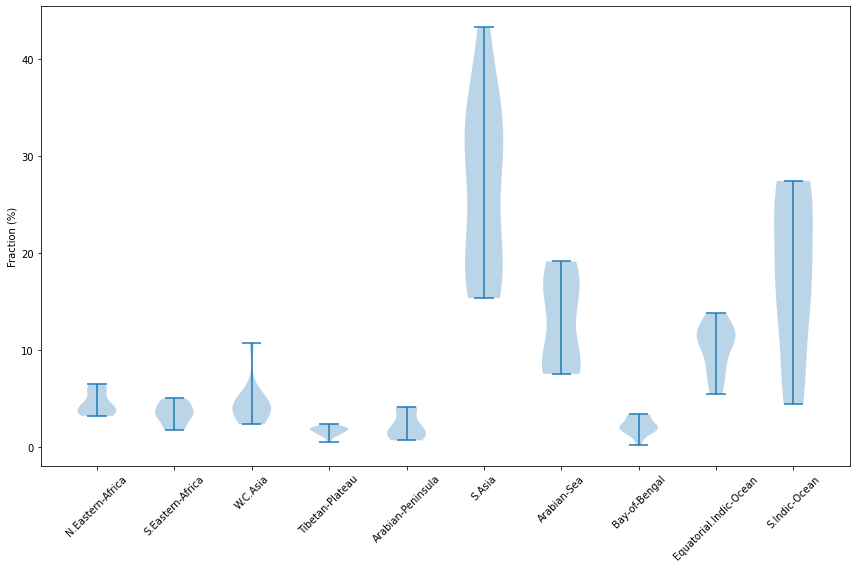

In [23]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.violinplot(srcs_regional_combined)
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(srcs_regional_combined.names.values, rotation=45)
ax.set_ylabel("Fraction (%)")
plt.tight_layout()
plt.savefig("Fraction_per_region.png",dpi=300)